## General Model



## Import useful packages

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
import boto3
import io
from keras.utils import plot_model
import random



Using TensorFlow backend.


## Define functions to load the data


#### This code gets list of keys (ie files) in S3 bucket
(Should consider moving this into a helper file.)

In [2]:
def get_matching_s3_objects(bucket, prefix="", suffix=""):
    """
    Generate objects in an S3 bucket.

    :param bucket: Name of the S3 bucket.
    :param prefix: Only fetch objects whose key starts with
        this prefix (optional).
    :param suffix: Only fetch objects whose keys end with
        this suffix (optional).
    """
    s3 = boto3.client("s3")
    paginator = s3.get_paginator("list_objects_v2")

    kwargs = {'Bucket': bucket}

    # We can pass the prefix directly to the S3 API.  If the user has passed
    # a tuple or list of prefixes, we go through them one by one.
    if isinstance(prefix, str):
        prefixes = (prefix, )
    else:
        prefixes = prefix

    for key_prefix in prefixes:
        kwargs["Prefix"] = key_prefix

        for page in paginator.paginate(**kwargs):
            try:
                contents = page["Contents"]
            except KeyError:
                break

            for obj in contents:
                key = obj["Key"]
                if key.endswith(suffix):
                    yield obj


def get_matching_s3_keys(bucket, prefix="", suffix=""):
    """
    Generate the keys in an S3 bucket.

    :param bucket: Name of the S3 bucket.
    :param prefix: Only fetch keys that start with this prefix (optional).
    :param suffix: Only fetch keys that end with this suffix (optional).
    """
    obj_list=[]
    for obj in get_matching_s3_objects(bucket, prefix, suffix):
        obj_list.append(obj["Key"])
    return(obj_list)


### Key image read-in functions: load_image and build_input

In [3]:
def load_image(s3_client,bucket_name,file_name, dim=(224,224)):
    """
    Loads a single image as a Numpy array and resizes it as
    desired.  The default dimensions are consistent with
    those expected by the VGG models.  

    Args:
    s3_client:  s3 resource
    bucket_name:name of bucket
    file_name:  file to convert to image

    dim: Two-element tuple giving the desired height
         and width of the processed image

    Returns:
    image:  A single-channel Numpy array
    """
    #image = cv2.imread(image_path, 0)
    file_stream = io.BytesIO()
    s3.download_fileobj(bucket_name,file_name,file_stream)
    nparr = np.frombuffer(file_stream.getvalue(), np.uint8)
    image=cv2.imdecode(nparr,0)
    image = cv2.resize(image, dim)#, interpolation = cv2.INTER_AREA)
    return image

In [4]:
def build_input(s3_client,bucket_name,file_list,files_to_load,dim):
    """
    Loads all of the images into a single numpy array.
    Assumes that there are 101 equally-spaced images
    spanning lattitudes from 35N to 45N.  

    Args:
    s3_client:  s3 resource
    bucket_name:name of bucket
    file_list:  list of files in bucket
    Returns:
    X:  A 3-dimensional numpy array containing the
        images. Image height and width are set by
        `load_images` and default to 224 x 224.

    y:  A 1-dimensional numpy array of target lattitudes.
    """
    X = []
    i=0
    for file in file_list[0:files_to_load]:
        if file[-4:] == '.png':
            print(file)
            image = load_image(s3_client,bucket_name,file,dim)
            X.append(image)
            if i%100==0:
                print('loaded:',i)
            i+=1
    return (np.array(X) / 255)

In [5]:
def build_labels(file_list,files_to_load):
    y = []
    for file in file_list[0:files_to_load]:
        if file[-4:] == '.png':
            file_split = file.split('+')
            lat = float(file_split[0])
            long = float(file_split[1])
            y.append((lat, long))
    return np.array(y)

#### Test load_image on one image manually

(540, 960)


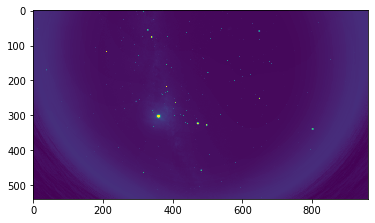

In [6]:
bucket_name='w251-final-project'
file_name='30.00016404896498+-54.75229869627509+2020-07-04T01:00:00.png'
s3 = boto3.client('s3')
sample_image = load_image(s3,bucket_name,file_name,(960,540))
plt.imshow(sample_image)
print(sample_image.shape)

## Prepare the data

### Load the images

In [8]:
#clear out models for memory management purposes
tf.keras.backend.clear_session()

#change this to true to force it to reload from S3 bucket
force_load=True

#check if np arrays have already been saved and load if so
if ((os.path.exists('x.npy'))&(not force_load)):
    print('loading from files')
    X=np.load('x.npy')
    y=np.load('y.npy')

#otherwise go to S3 bucket
else:
    print('loading from S3')
    bucket_name='w251-final-project'
    file_list=get_matching_s3_keys(bucket_name)
    
    #shuffle file list so that if take less than all are distributed.  also makes array randomly shuffled
    random.shuffle(file_list)
    
    s3 = boto3.client('s3')

    #max_files=100000
    max_files=5000
    file_list_length=len(file_list)
    files_to_load=np.minimum(max_files,file_list_length)

    #get images
    print('about to call build_input on',files_to_load,' files')
    dim=(960,540)
    X = build_input(s3,bucket_name,file_list,files_to_load,dim)


    #get labels
    print ('building labels')
    y = build_labels(file_list,files_to_load)
    
    print ('saving arrays so can reload more easily next time through')
#    np.save('x.npy',X)
#    np.save('y.npy',y)

print ('shape of image array:', X.shape)
print ('shape of label list:', y.shape)

loading from S3
about to call build_input on 2000  files
36.8245334122219+-53.169558017709164+2020-07-04T01:00:00.png
loaded: 0
45.38182077845419+-60.885688313613834+2020-07-04T01:00:00.png
42.59697710570413+-50.66741436537224+2020-07-04T01:00:00.png
43.035345017858326+-50.04733062000112+2020-07-04T01:00:00.png
33.31710316428832+-63.363608024485394+2020-07-04T01:00:00.png
37.320186008585125+-67.9383046670954+2020-07-04T01:00:00.png
33.302688240785855+-63.825460197610056+2020-07-04T01:00:00.png
44.433605155034854+-57.416194688080495+2020-07-04T01:00:00.png
37.0452045234568+-60.27035297054677+2020-07-04T01:00:00.png
30.74444406743191+-50.947717239896356+2020-07-04T01:00:00.png
44.661721346596536+-50.95091140748569+2020-07-04T01:00:00.png
41.593076915441166+-66.48084336207482+2020-07-04T01:00:00.png
41.62166577302762+-56.735283215150005+2020-07-04T01:00:00.png
45.175550383631645+-63.61510933772751+2020-07-04T01:00:00.png
47.95793990048095+-52.01538396491405+2020-07-04T01:00:00.png
37.7110

45.52389687939899+-67.14814646219203+2020-07-04T01:00:00.png
49.66453546629896+-57.753065238767306+2020-07-04T01:00:00.png
33.41114375586992+-58.55339930441188+2020-07-04T01:00:00.png
43.815382632505795+-52.42958368082895+2020-07-04T01:00:00.png
46.19777688941573+-58.446447986722845+2020-07-04T01:00:00.png
39.76605396805766+-59.20395361381847+2020-07-04T01:00:00.png
45.800029613867096+-61.0801246549134+2020-07-04T01:00:00.png
49.67989851810955+-62.88591682381515+2020-07-04T01:00:00.png
35.86251492394409+-55.25169955342656+2020-07-04T01:00:00.png
31.2997401625176+-58.51394658346176+2020-07-04T01:00:00.png
35.8168507348734+-67.87352935706915+2020-07-04T01:00:00.png
48.953060682681866+-52.44204731986585+2020-07-04T01:00:00.png
37.75383635106563+-62.65969665282046+2020-07-04T01:00:00.png
49.37961100783468+-55.51213917021793+2020-07-04T01:00:00.png
44.69745860331179+-59.64799280115092+2020-07-04T01:00:00.png
47.488760280394025+-51.35833357985439+2020-07-04T01:00:00.png
44.26433098603208+-67

37.950053428430365+-60.71753162825025+2020-07-04T01:00:00.png
45.60614666362982+-60.5048243544517+2020-07-04T01:00:00.png
35.992028743627195+-54.76549737874837+2020-07-04T01:00:00.png
46.75913699747912+-55.00400369596772+2020-07-04T01:00:00.png
39.94838486279214+-65.96525469396191+2020-07-04T01:00:00.png
46.174623978624496+-63.81956537165057+2020-07-04T01:00:00.png
40.749808654406394+-51.64169219706437+2020-07-04T01:00:00.png
42.193399834726314+-54.20528398467381+2020-07-04T01:00:00.png
42.263536675740255+-53.037011002921204+2020-07-04T01:00:00.png
48.0539358042536+-59.72495372029509+2020-07-04T01:00:00.png
30.45012154039101+-54.84993271898031+2020-07-04T01:00:00.png
45.35522404056954+-50.31713995071608+2020-07-04T01:00:00.png
43.599795951027055+-64.22692370477488+2020-07-04T01:00:00.png
43.719542003747094+-60.166758876972146+2020-07-04T01:00:00.png
32.97250252637291+-57.38560961657753+2020-07-04T01:00:00.png
49.02300898808982+-66.30189080880959+2020-07-04T01:00:00.png
48.8859033729935

49.4261866850658+-62.323572383533914+2020-07-04T01:00:00.png
48.02667096206093+-56.337587239899506+2020-07-04T01:00:00.png
47.296473949050856+-59.55314648087105+2020-07-04T01:00:00.png
46.16014357646404+-59.896540014323335+2020-07-04T01:00:00.png
49.56460181838692+-50.81456873926568+2020-07-04T01:00:00.png
35.88255320695855+-68.25031067507408+2020-07-04T01:00:00.png
47.315198969371984+-64.24177711869766+2020-07-04T01:00:00.png
42.35479396981939+-55.524833244651944+2020-07-04T01:00:00.png
47.11759649461189+-52.85546488812712+2020-07-04T01:00:00.png
39.457630174821944+-54.983160483961726+2020-07-04T01:00:00.png
41.09492469771823+-52.35193024131331+2020-07-04T01:00:00.png
49.55385685592826+-51.608607912268226+2020-07-04T01:00:00.png
46.22411975496017+-60.89834718890711+2020-07-04T01:00:00.png
43.80771761083795+-58.89947487361117+2020-07-04T01:00:00.png
35.8540786333193+-57.31658736499759+2020-07-04T01:00:00.png
48.548973291564295+-53.44290227441273+2020-07-04T01:00:00.png
36.9347499459760

35.078540245173514+-55.953124218416896+2020-07-04T01:00:00.png
34.9273906618195+-54.65697999938169+2020-07-04T01:00:00.png
48.84545775120016+-57.456076583534035+2020-07-04T01:00:00.png
43.47129945512317+-50.12883843460138+2020-07-04T01:00:00.png
42.418821017103596+-50.58024615371913+2020-07-04T01:00:00.png
47.52324284805114+-57.721830227550456+2020-07-04T01:00:00.png
37.40062181817633+-68.6497855184782+2020-07-04T01:00:00.png
44.10333234407779+-53.58666285313872+2020-07-04T01:00:00.png
33.00564909324191+-61.77624644945402+2020-07-04T01:00:00.png
47.79804587203551+-51.6662229393322+2020-07-04T01:00:00.png
32.96950457685564+-65.10777050740279+2020-07-04T01:00:00.png
44.81732461912373+-50.87921410600825+2020-07-04T01:00:00.png
41.676975968715325+-51.535660089512334+2020-07-04T01:00:00.png
44.380168275782985+-53.81904453736047+2020-07-04T01:00:00.png
36.07554135108113+-50.9566991762764+2020-07-04T01:00:00.png
41.17078308764286+-64.37091140918012+2020-07-04T01:00:00.png
33.99192938185507+-6

48.489654336562324+-50.845525621144745+2020-07-04T01:00:00.png
42.96530600569551+-62.74319781086258+2020-07-04T01:00:00.png
34.16577452121712+-58.05480993334736+2020-07-04T01:00:00.png
31.507016778430035+-61.467218099805365+2020-07-04T01:00:00.png
32.552793394948466+-69.37073036934358+2020-07-04T01:00:00.png
49.63004590026456+-64.96318969901655+2020-07-04T01:00:00.png
47.372008853270984+-54.74778365039761+2020-07-04T01:00:00.png
43.02344782906033+-68.3382378159997+2020-07-04T01:00:00.png
46.71987780617209+-62.18381553675625+2020-07-04T01:00:00.png
39.314548248624874+-52.982997862598054+2020-07-04T01:00:00.png
41.112584959664815+-68.62612405926423+2020-07-04T01:00:00.png
33.77140673403933+-60.14783060656177+2020-07-04T01:00:00.png
38.71928942449156+-68.43041748641387+2020-07-04T01:00:00.png
37.17039310181009+-51.19632265669527+2020-07-04T01:00:00.png
34.4819005367959+-58.088470852346006+2020-07-04T01:00:00.png
45.351543456867326+-64.18229313555811+2020-07-04T01:00:00.png
33.045897766186

40.47221377935925+-50.96461615977148+2020-07-04T01:00:00.png
48.3139772483919+-59.06993844789335+2020-07-04T01:00:00.png
41.47807780574973+-63.52271467093472+2020-07-04T01:00:00.png
49.60840854844187+-64.83627298480144+2020-07-04T01:00:00.png
46.42165694030344+-53.99972805249608+2020-07-04T01:00:00.png
35.165340541119136+-63.62333235064956+2020-07-04T01:00:00.png
31.13201264212695+-62.68279303826919+2020-07-04T01:00:00.png
45.40796882795381+-66.77681259388112+2020-07-04T01:00:00.png
47.16878837387376+-66.86346773580894+2020-07-04T01:00:00.png
38.478966971941766+-61.62420037558855+2020-07-04T01:00:00.png
30.543422114467962+-54.78528943489204+2020-07-04T01:00:00.png
34.90604674341986+-66.19439230947008+2020-07-04T01:00:00.png
39.87710566326311+-64.14429434844216+2020-07-04T01:00:00.png
31.10794977009981+-62.62970047620392+2020-07-04T01:00:00.png
32.55791339323916+-55.2138724617936+2020-07-04T01:00:00.png
45.93761527983666+-65.79658966456498+2020-07-04T01:00:00.png
33.12255250514751+-60.1

35.14996139788916+-60.61423941044242+2020-07-04T01:00:00.png
30.075256721395025+-51.78462225730168+2020-07-04T01:00:00.png
46.8559252499108+-58.53119706057846+2020-07-04T01:00:00.png
44.03558874540795+-56.247369942079374+2020-07-04T01:00:00.png
47.97288961413984+-69.66011094163184+2020-07-04T01:00:00.png
46.975657429168706+-52.228634617424746+2020-07-04T01:00:00.png
40.51673880201409+-52.62858767450287+2020-07-04T01:00:00.png
45.38966075137897+-55.62773225018854+2020-07-04T01:00:00.png
44.62701415308481+-65.42884892326141+2020-07-04T01:00:00.png
47.31838274659886+-60.04126480275606+2020-07-04T01:00:00.png
44.43277280545215+-66.23625943571639+2020-07-04T01:00:00.png
48.381125607209206+-69.8061021356573+2020-07-04T01:00:00.png
38.45009939814701+-61.949866715031945+2020-07-04T01:00:00.png
31.19298365159635+-54.94574833421208+2020-07-04T01:00:00.png
40.93376839956125+-51.65147869533954+2020-07-04T01:00:00.png
30.498207473048602+-67.89788914077721+2020-07-04T01:00:00.png
38.37866696443565+-

36.63660299548973+-50.74498070915698+2020-07-04T01:00:00.png
38.94744359084241+-69.27390762449896+2020-07-04T01:00:00.png
31.358393885525054+-64.42075153332672+2020-07-04T01:00:00.png
48.385767816081966+-56.265222158454904+2020-07-04T01:00:00.png
43.136230310173964+-61.725634469793214+2020-07-04T01:00:00.png
49.04326882802167+-60.67541201991685+2020-07-04T01:00:00.png
36.669761116093724+-60.66623256567196+2020-07-04T01:00:00.png
32.55586578730338+-68.85847769011096+2020-07-04T01:00:00.png
43.83301689914889+-66.09844596430217+2020-07-04T01:00:00.png
47.874302585441754+-60.18413832432148+2020-07-04T01:00:00.png
37.493561237161074+-65.82991079255424+2020-07-04T01:00:00.png
35.036371332518435+-69.25811012196414+2020-07-04T01:00:00.png
37.88055002851059+-60.01095451377827+2020-07-04T01:00:00.png
42.84317304989669+-53.81171414361705+2020-07-04T01:00:00.png
47.7550174159831+-62.96568956695164+2020-07-04T01:00:00.png
36.95756016649126+-54.34102341499998+2020-07-04T01:00:00.png
36.4288343115133

45.180186369716466+-62.457589870841716+2020-07-04T01:00:00.png
45.12720679732423+-63.72503041358135+2020-07-04T01:00:00.png
36.42184483170894+-62.96345170675484+2020-07-04T01:00:00.png
31.71821581235569+-66.7314915750183+2020-07-04T01:00:00.png
36.8293193416732+-55.62699335946234+2020-07-04T01:00:00.png
31.00471543059724+-62.15295649265436+2020-07-04T01:00:00.png
48.30906422293813+-61.63139947850828+2020-07-04T01:00:00.png
46.68388924075087+-54.568585305025+2020-07-04T01:00:00.png
33.321027368625785+-65.1507546109329+2020-07-04T01:00:00.png
34.899322919092995+-66.4166556029452+2020-07-04T01:00:00.png
46.46478189516341+-59.73373413825898+2020-07-04T01:00:00.png
39.871820442765674+-63.5102994831429+2020-07-04T01:00:00.png
46.24936250282974+-52.783830745836894+2020-07-04T01:00:00.png
37.451593032382625+-60.33423328904667+2020-07-04T01:00:00.png
30.084935856529697+-61.55835798453869+2020-07-04T01:00:00.png
39.27030122898421+-67.5485025597887+2020-07-04T01:00:00.png
40.01745209141565+-51.48

48.28010016310557+-50.73407684066339+2020-07-04T01:00:00.png
37.97207700922643+-57.8711133418483+2020-07-04T01:00:00.png
45.145565703348936+-50.95119769281449+2020-07-04T01:00:00.png
48.112771745787995+-58.570438761811914+2020-07-04T01:00:00.png
47.04588726334242+-69.30604253123015+2020-07-04T01:00:00.png
35.68480585959615+-60.978891849289525+2020-07-04T01:00:00.png
49.476299032901274+-55.07532762132828+2020-07-04T01:00:00.png
38.19671433337046+-56.36396723487888+2020-07-04T01:00:00.png
43.45804835792981+-69.85754021476293+2020-07-04T01:00:00.png
31.084467120032254+-61.1581219536735+2020-07-04T01:00:00.png
33.03363649598008+-63.56421284530398+2020-07-04T01:00:00.png
34.43043751911533+-62.35940174221844+2020-07-04T01:00:00.png
41.100932487451644+-56.1328296510999+2020-07-04T01:00:00.png
45.46696756290345+-60.81030041848728+2020-07-04T01:00:00.png
49.42565914714993+-52.31054772624273+2020-07-04T01:00:00.png
38.46683373036618+-60.54293711413386+2020-07-04T01:00:00.png
44.19533560513689+-6

35.160487789479305+-62.2841267484453+2020-07-04T01:00:00.png
37.59012919939571+-66.52852478528598+2020-07-04T01:00:00.png
30.939943697355336+-52.744289775743695+2020-07-04T01:00:00.png
33.527541645657536+-58.18153061953032+2020-07-04T01:00:00.png
33.02046954324424+-67.81610350943144+2020-07-04T01:00:00.png
49.43692753587064+-55.43273527615095+2020-07-04T01:00:00.png
38.36423981117593+-59.896228995323604+2020-07-04T01:00:00.png
44.01043214010098+-53.786070869446164+2020-07-04T01:00:00.png
30.93885278452795+-60.97594627591387+2020-07-04T01:00:00.png
40.4171469261469+-59.75687389656091+2020-07-04T01:00:00.png
31.169159248732605+-51.66096540768644+2020-07-04T01:00:00.png
45.54712352921841+-60.85837490378221+2020-07-04T01:00:00.png
38.71800956563266+-53.901207208218594+2020-07-04T01:00:00.png
49.888077287017005+-57.35534925349529+2020-07-04T01:00:00.png
45.18893636216309+-51.61318339057331+2020-07-04T01:00:00.png
39.962919896765726+-66.30462129955475+2020-07-04T01:00:00.png
47.8860750214327

37.28651273960843+-68.89731234451934+2020-07-04T01:00:00.png
38.69845614998012+-54.865827285308114+2020-07-04T01:00:00.png
38.03041210717589+-54.18505523940351+2020-07-04T01:00:00.png
47.89224961004298+-57.9570084030024+2020-07-04T01:00:00.png
47.200363731343884+-58.10989104070554+2020-07-04T01:00:00.png
45.68316704173286+-57.610899520799165+2020-07-04T01:00:00.png
31.05056113657596+-57.26563230289234+2020-07-04T01:00:00.png
39.11749254304286+-51.579374277642465+2020-07-04T01:00:00.png
47.868302451862874+-50.415881438604956+2020-07-04T01:00:00.png
35.69067357210258+-51.361324416832375+2020-07-04T01:00:00.png
44.92694492084131+-60.805682980252605+2020-07-04T01:00:00.png
36.081317534325656+-59.462851064963246+2020-07-04T01:00:00.png
44.26916346585624+-52.91799534880524+2020-07-04T01:00:00.png
44.18587577581578+-50.41049508960408+2020-07-04T01:00:00.png
40.180942506939374+-58.52479622019764+2020-07-04T01:00:00.png
35.49747127244482+-58.2703557809305+2020-07-04T01:00:00.png
46.572383696494

45.7024011820162+-53.89837065290206+2020-07-04T01:00:00.png
40.402497720935784+-53.138129875622525+2020-07-04T01:00:00.png
39.762582342162105+-61.544661264012966+2020-07-04T01:00:00.png
49.76625195132184+-66.2905468526179+2020-07-04T01:00:00.png
30.30022152668679+-52.223546435527496+2020-07-04T01:00:00.png
47.36880176476732+-57.78318742616162+2020-07-04T01:00:00.png
38.01574617259675+-68.85634042865036+2020-07-04T01:00:00.png
43.510366626179945+-59.64701279880004+2020-07-04T01:00:00.png
47.31668375566278+-64.66799814679463+2020-07-04T01:00:00.png
49.56719311525199+-51.72506321169302+2020-07-04T01:00:00.png
32.706020215740956+-59.17372219529322+2020-07-04T01:00:00.png
33.170000240289504+-54.19612720478753+2020-07-04T01:00:00.png
43.87503757073737+-66.2789386926095+2020-07-04T01:00:00.png
36.632422850566066+-59.328437504041396+2020-07-04T01:00:00.png
31.916287140055157+-60.75274148652632+2020-07-04T01:00:00.png
44.986211768638604+-55.414743363241584+2020-07-04T01:00:00.png
34.39349307074

44.71075939319394+-56.80179739001371+2020-07-04T01:00:00.png
43.58197375240619+-66.44066701762533+2020-07-04T01:00:00.png
35.78844512347702+-62.87309514239999+2020-07-04T01:00:00.png
48.24563683380469+-67.43581073199093+2020-07-04T01:00:00.png
34.78265220080575+-68.7363736635541+2020-07-04T01:00:00.png
42.27963554559321+-51.09473767738356+2020-07-04T01:00:00.png
46.74615305016718+-57.328105838549284+2020-07-04T01:00:00.png
49.20953258247518+-66.71230984304167+2020-07-04T01:00:00.png
37.753232997454354+-59.19652789898079+2020-07-04T01:00:00.png
46.715239419842355+-67.08032289368485+2020-07-04T01:00:00.png
34.43795743708976+-68.51932712088461+2020-07-04T01:00:00.png
38.30541885174641+-51.494721024987086+2020-07-04T01:00:00.png
38.22318409019921+-56.87704012272022+2020-07-04T01:00:00.png
loaded: 1900
40.45415990274936+-62.001018048817926+2020-07-04T01:00:00.png
31.15829302774533+-68.22571621612947+2020-07-04T01:00:00.png
44.45117284774405+-64.05729502560949+2020-07-04T01:00:00.png
30.6625


### Standardize the values

In [9]:
def scale_down(numbers):
    top=max(numbers)
    bottom=min(numbers)
    middle=(top+bottom)/2
    number_range=top-bottom
    revised=[x-middle for x in numbers]
    revised=[x/number_range*2 for x in revised]
    return revised,top,bottom

def scale_up(numbers,top,bottom):
    middle=(top+bottom)/2
    number_range=top-bottom
    revised=[x*number_range/2 for x in numbers]
    revised=[x+middle for x in revised]
    return revised

In [10]:
#just scaling down without normalizing
y[:,0],toplat,bottomlat=scale_down(y[:,0])
y[:,1],toplong,bottomlong=scale_down(y[:,1])

#y[:,0] = scale(y[:,0])
#y[:,1]=scale(y[:,1])

print (y[:,0].mean(),y[:,0].std())
print (y[:,1].mean(),y[:,1].std())

0.003999809053089002 0.5861410907607695
0.012550348381731365 0.5835241451376693


### Split into test and training sets

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(1600, 540, 960)
(1600, 2)
(400, 540, 960)
(400, 2)


### Add channel for CNN

In [12]:
#need to add channel for B&W for CNN
#https://machinelearningmastery.com/a-gentle-introduction-to-channels-first-and-channels-last-image-formats-for-deep-learning/

print(X_train.shape,y_train.shape)
X_train=np.expand_dims(X_train,axis=3)
X_val=np.expand_dims(X_val,axis=3)
print(X_train.shape,X_val.shape)

(1600, 540, 960) (1600, 2)
(1600, 540, 960, 1) (400, 540, 960, 1)


## The model

[]

In [12]:
tf.keras.backend.clear_session()

In [20]:
input_shape=(224,224,1)
inputs = tf.keras.layers.Input(shape=input_shape)
x=tf.keras.layers.Conv2D(64,(3,3),activation='relu')(inputs)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Conv2D(64,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Dropout(0.25)(x)
x=tf.keras.layers.Conv2D(128,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Conv2D(128,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Dropout(0.25)(x)

x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(256,activation='relu')(x)
x=tf.keras.layers.Dropout(0.5)(x)
x=tf.keras.layers.Dense(64,activation='relu')(x)
regression_layer_lat = tf.keras.layers.Dense(1, name='regression_lat')(x)  
regression_layer_long = tf.keras.layers.Dense(1, name='regression_long')(x)

model_output = [regression_layer_lat, regression_layer_long]
losses = ['mean_squared_error', 'mean_squared_error']
metrics = ['mean_squared_error', 'mean_squared_error']

model = tf.keras.models.Model(inputs, model_output)
model.compile(loss=losses,  optimizer='adam', metrics=metrics)

In [13]:
#model splits into lat long after convolutional layers

input_shape=(540,960,1)
inputs = tf.keras.layers.Input(shape=input_shape)
x=tf.keras.layers.Conv2D(64,(3,3),activation='relu')(inputs)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Conv2D(64,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Dropout(0.25)(x)
x=tf.keras.layers.Conv2D(128,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Conv2D(128,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Dropout(0.25)(x)
x=tf.keras.layers.Flatten()(x)

xlat=tf.keras.layers.Dense(256,activation='relu')(x)
xlat=tf.keras.layers.Dropout(0.5)(xlat)
xlat=tf.keras.layers.Dense(64,activation='relu')(xlat)
regression_layer_lat = tf.keras.layers.Dense(1, name='regression_lat')(xlat)  

xlong=tf.keras.layers.Dense(256,activation='relu')(x)
xlong=tf.keras.layers.Dropout(0.5)(xlong)
xlong=tf.keras.layers.Dense(64,activation='relu')(xlong)
regression_layer_long = tf.keras.layers.Dense(1, name='regression_long')(xlong)

model_output = [regression_layer_lat, regression_layer_long]
losses = ['mean_squared_error', 'mean_squared_error']
metrics = ['mean_squared_error', 'mean_squared_error']

model = tf.keras.models.Model(inputs, model_output)
model.compile(loss=losses,  optimizer='adam', metrics=metrics)

In [14]:
print(model.summary())
#plot_model(model)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 540, 960, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 538, 958, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 269, 479, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 267, 477, 64) 36928       max_pooling2d[0][0]              
______________________________________________________________________________________________

### Fit the model

In [15]:
history = model.fit(x=X_train, 
                    y=[y_train[:,0],y_train[:,1]],
                    validation_data=[X_val,[y_val[:,0],y_val[:,1]]],
                    verbose=1, epochs=15, batch_size=32)

Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 186s 116ms/sample - loss: 1.1727 - regression_lat_loss: 0.3771 - regression_long_loss: 0.7956 - regression_lat_mean_squared_error: 0.3771 - regression_long_mean_squared_error: 0.7956 - val_loss: 0.0869 - val_regression_lat_loss: 0.0443 - val_regression_long_loss: 0.0424 - val_regression_lat_mean_squared_error: 0.0444 - val_regression_long_mean_squared_error: 0.0425
Epoch 2/15
1600/1600 [==============================] - 180s 113ms/sample - loss: 0.0299 - regression_lat_loss: 0.0171 - regression_long_loss: 0.0128 - regression_lat_mean_squared_error: 0.0171 - regression_long_mean_squared_error: 0.0128 - val_loss: 0.0371 - val_regression_lat_loss: 0.0196 - val_regression_long_loss: 0.0173 - val_regression_lat_mean_squared_error: 0.0197 - val_regression_long_mean_squared_error: 0.0173
Epoch 3/15
1600/1600 [==============================] - 180s 112ms/sample - loss: 0.0248 - regression_lat

### Evaluate model performance

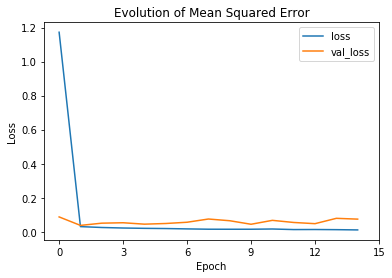

In [16]:
history_df = pd.DataFrame(history.history)
ax = history_df.plot(y=['loss', 'val_loss'],
                xticks=np.linspace(0, len(history_df), 6))
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_title('Evolution of Mean Squared Error')
plt.show()


In [17]:
y_hat = model.predict(X_val)
#y_hat_lat=model.predict(X_val)[0]
#y_hat_long=model.predict(X_val)[1]
y_hat_lat=y_hat[0]
y_hat_long=y_hat[1]

y_hat_lat=scale_up(y_hat_lat,toplat,bottomlat)
y_hat_long=scale_up(y_hat_long,toplong,bottomlong)

y_val_lat=y_val[:,0]
y_val_long=y_val[:,1]

y_val_lat=scale_up(y_val_lat,toplat,bottomlat)
y_val_long=scale_up(y_val_long,toplong,bottomlong)

(30, 50)

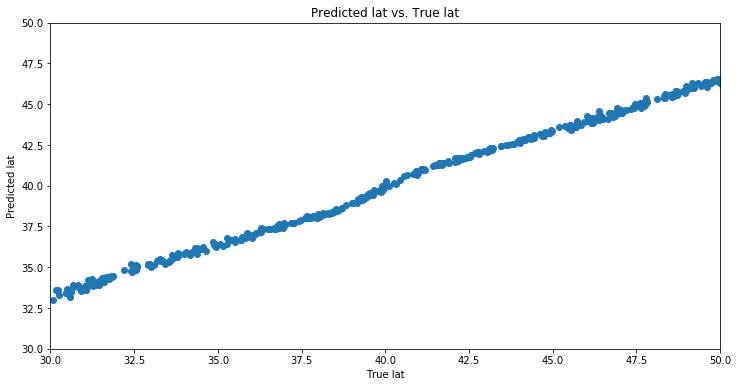

In [18]:
fig = plt.figure(figsize=(12,6))
ax=fig.add_subplot(111)
ax.scatter(y_val_lat, y_hat_lat)
plt.title('Predicted lat vs. True lat')
plt.xlabel('True lat')
plt.ylabel('Predicted lat')
ax.set_xlim(30,50)
ax.set_ylim(30,50)
#draw straight line


(-70, -50)

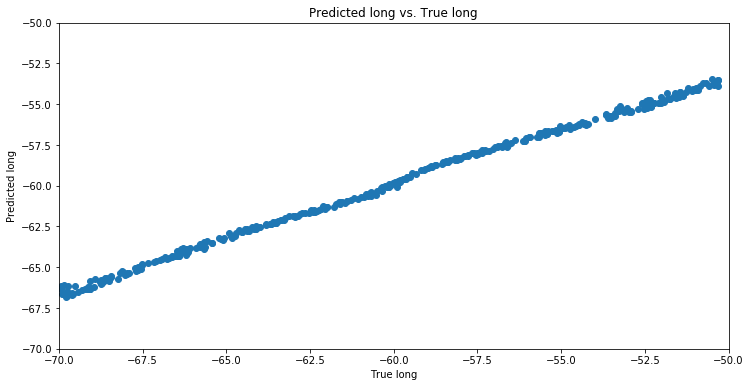

In [19]:
fig = plt.figure(figsize=(12,6))
ax=fig.add_subplot(111)
ax.scatter(y_val_long, y_hat_long)
plt.title('Predicted long vs. True long')
plt.xlabel('True long')
plt.ylabel('Predicted long')
ax.set_xlim(-70,-50)
ax.set_ylim(-70,-50)


### Feed Forward Dense

In [38]:
#just dense

input_shape=(224,224,1)
inputs = tf.keras.layers.Input(shape=input_shape)
x=tf.keras.layers.Flatten()(inputs)
x=tf.keras.layers.Dense(528,activation='relu')(x)
x=tf.keras.layers.Dense(528,activation='relu')(x)
x=tf.keras.layers.Dense(528,activation='relu')(x)

xlat=tf.keras.layers.Dense(256,activation='relu')(x)
xlat=tf.keras.layers.Dropout(0.25)(xlat)
xlat=tf.keras.layers.Dense(256,activation='relu')(xlat)
regression_layer_lat = tf.keras.layers.Dense(1, name='regression_lat')(xlat)  

xlong=tf.keras.layers.Dense(256,activation='relu')(x)
xlong=tf.keras.layers.Dropout(0.25)(xlong)
xlong=tf.keras.layers.Dense(256,activation='relu')(xlong)
regression_layer_long = tf.keras.layers.Dense(1, name='regression_long')(xlong)

model_output = [regression_layer_lat, regression_layer_long]
losses = ['mean_squared_error', 'mean_squared_error']
metrics = ['mean_squared_error', 'mean_squared_error']

model = tf.keras.models.Model(inputs, model_output)
model.compile(loss=losses,  optimizer='adam', metrics=metrics)
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 50176)        0           input_3[0][0]                    
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 528)          26493456    flatten_1[0][0]                  
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 528)          279312      dense_11[0][0]                   
____________________________________________________________________________________________

In [39]:
history = model.fit(x=X_train, 
                    y=[y_train[:,0],y_train[:,1]],
                    validation_data=[X_val,[y_val[:,0],y_val[:,1]]],
                    verbose=1, epochs=20, batch_size=128)

Train on 4000 samples, validate on 1000 samples
Epoch 1/20
4000/4000 [==============================] - 8s 2ms/sample - loss: 2.0387 - regression_lat_loss: 0.8447 - regression_long_loss: 1.1658 - regression_lat_mean_squared_error: 0.8550 - regression_long_mean_squared_error: 1.1837 - val_loss: 0.6580 - val_regression_lat_loss: 0.3201 - val_regression_long_loss: 0.3377 - val_regression_lat_mean_squared_error: 0.3201 - val_regression_long_mean_squared_error: 0.3379
Epoch 2/20
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.6928 - regression_lat_loss: 0.3413 - regression_long_loss: 0.3514 - regression_lat_mean_squared_error: 0.3413 - regression_long_mean_squared_error: 0.3516 - val_loss: 0.6555 - val_regression_lat_loss: 0.3144 - val_regression_long_loss: 0.3413 - val_regression_lat_mean_squared_error: 0.3143 - val_regression_long_mean_squared_error: 0.3412
Epoch 3/20
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.6259 - regression_lat_loss: 0.30

In [40]:
y_hat = model.predict(X_val)
#y_hat_lat=model.predict(X_val)[0]
#y_hat_long=model.predict(X_val)[1]
y_hat_lat=y_hat[0]
y_hat_long=y_hat[1]

y_hat_lat=scale_up(y_hat_lat,toplat,bottomlat)
y_hat_long=scale_up(y_hat_long,toplong,bottomlong)

y_val_lat=y_val[:,0]
y_val_long=y_val[:,1]

y_val_lat=scale_up(y_val_lat,toplat,bottomlat)
y_val_long=scale_up(y_val_long,toplong,bottomlong)

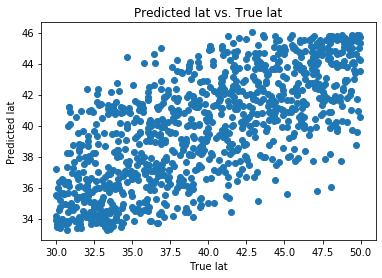

In [41]:
plt.scatter(y_val_lat, y_hat_lat)
plt.title('Predicted lat vs. True lat')
plt.xlabel('True lat')
plt.ylabel('Predicted lat')
plt.show()

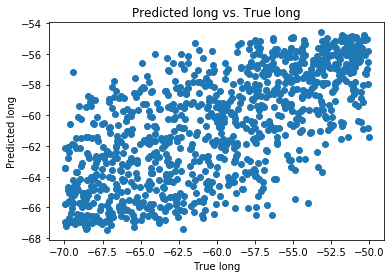

In [42]:
plt.scatter(y_val_long, y_hat_long)
plt.title('Predicted long vs. True long')
plt.xlabel('True long')
plt.ylabel('Predicted long')
plt.show()

### Things to consider doing:
- don't normalize the lat and long - just scale it DONE
- convert back to lat and long DONE
- set validation batch size to deal with OOM errors (possibly) DONE
- loss weights?
- what is resolution of png files coming in?  are they squares?
- since set wide rectangle, need to make sure entirely at night time
- change angle of view - look more tired horizon?


### Old models

In [ ]:
# Define Input layer(s)
inputShape = (224, 224)
inputs = tf.keras.layers.Input(shape=inputShape)

flatten = tf.keras.layers.Flatten()(inputs)

x=tf.keras.layers.Dense(512,activation='relu')(flatten)
x=tf.keras.layers.Dense(512,activation='relu')(x)
x=tf.keras.layers.Dense(512,activation='relu')(x)
x=tf.keras.layers.Dense(512,activation='relu')(x)
regression_layer_lat = tf.keras.layers.Dense(1, name='regression_lat')(x)  
regression_layer_long = tf.keras.layers.Dense(1, name='regression_long')(x)


# Build and compile model
model_input = inputs
model_output = [regression_layer_lat, regression_layer_long]
losses = ['mean_squared_error', 'mean_squared_error']
metrics = ['mean_squared_error', 'mean_squared_error']

model = tf.keras.models.Model(model_input, model_output)
model.compile(loss=losses,  optimizer='adam', metrics=metrics)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224,224)),
    tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2)
])